Section 1: Setup & Unzipping




**Purpose**

- Connect to Google Drive

- Unzip radar dataset

**Why unzip**

- Dataset stored as ZIP files to save space

- Extract to cloud server for faster access

- Reading directly from Drive is slow during training





In [ ]:
import os
import zipfile
import glob
from google.colab import drive
from tqdm import tqdm

drive.mount('/content/drive')

DATASET_DIR = '/content/drive/MyDrive/RadarDataset'
EXTRACT_DIR = '/content/temp_csv_data'

def unzip_csv_only(zip_path, target_dir):
    with zipfile.ZipFile(zip_path, 'r') as z:
        # Extract only CSVs
        csv_files = [f for f in z.namelist() if f.endswith('.csv')]
        z.extractall(target_dir, members=csv_files)

if os.path.exists(EXTRACT_DIR):
    import shutil
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)

# Find ALL zip files
zip_files = sorted(glob.glob(os.path.join(DATASET_DIR, "batch*.zip")))

print(f"Found {len(zip_files)} zip batches. extracting ALL of them...")

# Loop through ALL zip files (removed the [:1] limit)
for z in tqdm(zip_files):
    unzip_csv_only(z, EXTRACT_DIR)

print(f"✅ Full Extraction Complete in {EXTRACT_DIR}")

Mounted at /content/drive
Found 8 zip batches. extracting ALL of them...


100%|██████████| 8/8 [01:55<00:00, 14.50s/it]

✅ Full Extraction Complete in /content/temp_csv_data


Section 2: File Sorting (Time Alignment)


**Purpose**

- Read filenames

- Extract timestamps (e.g., 20240903_133100)

- Sort files chronologically

**Why sorting is important**

- Radar data is time-series

- Model learns sequence of rain events

- Wrong order breaks temporal patterns

- Storm movement cannot be learned if time is mixed

In [ ]:
import glob
import os
import re

# 1. Regex to find the timestamp in the filename
# Example filename: "20240910_034200_Rain_000.csv"
# We want to extract: "20240910_034200" to sort by it
TS_PATTERN = re.compile(r'(\d{8}_\d{6})_Rain_000')

def get_sorted_csv_files(root_dir):
    # Get ALL csv files in the folder
    all_files = glob.glob(os.path.join(root_dir, '**', '*.csv'), recursive=True)

    valid_files = []
    for f in all_files:
        # Check if filename has a valid timestamp
        match = TS_PATTERN.search(os.path.basename(f))
        if match:
            # We store a tuple: (Timestamp, FilePath)
            valid_files.append((match.group(1), f))

    # 2. Sort the list based on the Timestamp (the first item in tuple)
    valid_files.sort(key=lambda x: x[0])

    # Return just the sorted paths
    return [f[1] for f in valid_files]

# EXECUTE
sorted_csv_paths = get_sorted_csv_files(EXTRACT_DIR)

print(f"Total CSV files found: {len(sorted_csv_paths)}")

# Check the first 3 to make sure they are in order!
print("First 3 files:", sorted_csv_paths[:3])

Total CSV files found: 38929
First 3 files: ['/content/temp_csv_data/batch1/xmpr_001/20240903_133100_Rain_000.csv', '/content/temp_csv_data/batch1/xmpr_001/20240903_133200_Rain_000.csv', '/content/temp_csv_data/batch1/xmpr_001/20240903_133300_Rain_000.csv']


Section 3: Preprocessing

**Steps**

- Read CSV files

- Replace -999.0 → 0.0

- Apply Min-Max Scaling (0–1)

**Why replace -999**

- -999 = no data / background noise

- Interpreted as zero rainfall

- Prevents extreme values from skewing training

**Why normalization**

- Neural networks work better with small values

- Reduces large variance in rainfall intensity

- Faster and more stable model convergence

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

# We no longer limit the files
# MAX_FILES = 2000  <-- DELETED

def read_csv_features(path):
    try:
        # Read file, skipping header to get to Row 11
        df = pd.read_csv(path, skiprows=10, header=None)

        # Take the FIRST row of the data
        row_data = df.iloc[0].values.astype(np.float32)

        # Clean Bad Values
        row_data[row_data == -999.0] = 0.0
        row_data = np.nan_to_num(row_data, nan=0.0)

        return row_data
    except Exception as e:
        return None

In [ ]:
# --- 1. DETECT FEATURE COUNT ---
# Read the first file to set the feature count dynamically
first_file_path = sorted_csv_paths[0]
sample_data = read_csv_features(first_file_path)

if sample_data is None:
    raise ValueError("Could not read the first file!")

CSV_FEATURES = len(sample_data)
TOTAL_FILES = len(sorted_csv_paths)

print(f"✅ Detected {CSV_FEATURES} spatial features.")
print(f"📂 Processing FULL DATASET: {TOTAL_FILES} files...")

✅ Detected 723 spatial features.
📂 Processing FULL DATASET: 38929 files...


In [ ]:
# --- 2. LOAD ALL DATA ---
raw_data_list = []

# Loop through ALL sorted paths (No slicing like [:MAX_FILES])
for path in tqdm(sorted_csv_paths):
    data_row = read_csv_features(path)

    if data_row is not None:
        if len(data_row) == CSV_FEATURES:
            raw_data_list.append(data_row)

raw_data_array = np.array(raw_data_list)

100%|██████████| 38929/38929 [17:16<00:00, 37.56it/s]


In [ ]:
# --- 3. NORMALIZE ---
scaler = MinMaxScaler()
scaled_csv_data = scaler.fit_transform(raw_data_array)

print(f"\n✅ Final Full Dataset Shape: {scaled_csv_data.shape}")


✅ Final Full Dataset Shape: (29096, 723)


Section 4: Sequence Creation & Splitting


**Steps**

- Create sliding windows

- Input (X): past 15 minutes

- Output (Y): next 15 minutes

**Split data**

- 70% Training

- 15% Validation

- 15% Testing

**Sliding window concept**

- Converts time-series → supervised learning

- Each sample has past frames + future target

- Suitable for nowcasting tasks

In [ ]:
def create_sequences(data, T_in, K_out):
    X, y = [], []
    n_samples = len(data)

    for i in range(n_samples - T_in - K_out + 1):
        # Input: Past T frames
        X.append(data[i : i + T_in])
        # Output: Future K frames
        y.append(data[i + T_in : i + T_in + K_out])

    return np.array(X), np.array(y)

def get_dataset_splits(data, T, K):
    X, y = create_sequences(data, T, K)

    # Split indices
    n = len(X)
    train_idx = int(n * 0.70)
    val_idx = int(n * 0.85)

    X_train, y_train = X[:train_idx], y[:train_idx]
    X_val, y_val = X[train_idx:val_idx], y[train_idx:val_idx]
    X_test, y_test = X[val_idx:], y[val_idx:]

    return X_train, y_train, X_val, y_val, X_test, y_test

print("Sequence creator ready.")

Sequence creator ready.


In [ ]:
# --- MODIFY Cell 10 (create_sequences) ---
def create_sequences(data, T_in, K_out):
    X, y = [], []
    n_samples = len(data)

    for i in range(n_samples - T_in - K_out + 1):
        # Input: Past T frames (Keep all 723 features)
        X.append(data[i : i + T_in])

        # Output: Future K frames
        # CHANGE: Take the MEAN of the future data to get 1 number per minute
        future_window = data[i + T_in : i + T_in + K_out]
        y.append(np.mean(future_window, axis=1)) # Shape becomes (K,) instead of (K, 723)

    return np.array(X), np.array(y)

Section 5: LSTM Model

**Model components**

LSTM (128 units)

- Learns temporal dependencies

Dropout (0.3)

- Prevents overfitting

Dense + Reshape

- Formats output into 15-minute forecast



In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

def build_lstm_csv(T, F, K, dropout=0.3, activation='tanh', learning_rate=0.001):
    inp = layers.Input(shape=(T, F))

    # LSTM Layers
    x = layers.LSTM(128, activation=activation, return_sequences=False)(inp)
    x = layers.Dropout(dropout)(x)

    # Dense Projection
    # OLD: out = layers.Dense(K * F)(x)  <-- Caused the error (723 features)

    # NEW: Predict only K numbers (Mean Rainfall for next K steps)
    out = layers.Dense(K)(x)

    # Reshape to (Batch, K, 1) or just (Batch, K) depending on preference.
    # We will keep it as (Batch, K) to match the simple y_train
    # No Reshape needed if y_train is (Batch, K)

    model = models.Model(inp, out)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mae'])
    return model

# Test Build
# F_TEST is usually 723
model_test = build_lstm_csv(T=15, F=723, K=15)
model_test.summary()

# 1. Define feature size if not already set (e.g., 722 spatial points)
if 'CSV_FEATURES' not in globals() or CSV_FEATURES is None:
    print("CSV_FEATURES variable not found. Using default F=722 for summary test.")
    F_TEST = 722
else:
    F_TEST = CSV_FEATURES

# 2. Build the model instance
# T=15 (History), F=Feature Count, K=15 (Forecast)
model_test = build_lstm_csv(T=15, F=F_TEST, K=15)

# 3. Print the summary
model_test.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 723)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 128)            │       436,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,159 (1.67 MB)

 Trainable params: 438,159 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 15, 723)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 128)            │       436,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 438,159 (1.67 MB)

 Trainable params: 438,159 (1.67 MB)

 Non-trainable params: 0 (0.00 B)

Section 6: Hyperparameter Tuning

What is tuned

- Window size (T)

- Learning rate

- Batch size

Method

- Grid Search

- Train multiple small models

- Compare validation loss

Chosen parameters

- 15-minute window

- Learning rate = 0.0005

- Lowest and most stable validation loss

In [ ]:
import tensorflow as tf
from tensorflow.keras import callbacks

In [ ]:
tuning_grid = {
    "history_windows": [15, 30, 60],   # T: How much past data to look at
    "forecast_horizons": [15],         # K: Predicting next 15 mins (Keep fixed or add 30)
    "learning_rates": [0.001, 0.0005], # Test standard vs slow learning
    "batch_sizes": [16, 32, 64],       # Test stability
    "dropouts": [0.2, 0.3],            # Regularization
    "activations": ['tanh']            # LSTM standard
}

best_val_loss = float("inf")
best_config = {}

In [ ]:
from tensorflow.keras import callbacks
import tensorflow as tf
import gc

print("Starting Hyperparameter Tuning...")
print(f"Testing Windows (T): {tuning_grid['history_windows']}")

for T in tuning_grid["history_windows"]:
    for K in tuning_grid["forecast_horizons"]:

        print(f"\n--- Preparing Data for T={T}, K={K} ---")
        Xtr, Ytr, Xval, Yval, _, _ = get_dataset_splits(scaled_csv_data, T, K)

        for lr in tuning_grid["learning_rates"]:
            for bs in tuning_grid["batch_sizes"]:
                for dr in tuning_grid["dropouts"]:
                    for act in tuning_grid["activations"]:

                        print(f"Testing: T={T} | LR={lr} | Batch={bs} ...", end=" ")

                        try:
                            # CALL THE NEW SCALAR MODEL
                            model = build_lstm_csv(T=T, F=CSV_FEATURES, K=K,
                                                   dropout=dr,
                                                   activation=act,
                                                   learning_rate=lr)

                            # STOP EARLY if it gets stuck
                            early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

                            history = model.fit(
                                Xtr, Ytr,
                                validation_data=(Xval, Yval),
                                epochs=15,
                                batch_size=bs,
                                callbacks=[early_stop],
                                verbose=0
                            )

                            val_loss = min(history.history['val_loss'])
                            print(f"-> Loss: {val_loss:.6f}") # Print 6 decimals to see tiny changes

                            if val_loss < best_val_loss:
                                best_val_loss = val_loss
                                best_config = {
                                    "T": T, "K": K, "lr": lr, "batch": bs,
                                    "dropout": dr, "activation": act,
                                    "val_loss": val_loss
                                }
                                print(f"   🌟 NEW BEST!")

                        except Exception as e:
                            print(f"Error: {e}")

                        tf.keras.backend.clear_session()
                        gc.collect()

print("\nBest Config:", best_config)

Starting Hyperparameter Tuning...
Testing Windows (T): [15, 30, 60]

--- Preparing Data for T=15, K=15 ---
Testing: T=15 | LR=0.001 | Batch=16 ... -> Loss: 0.000005
   🌟 NEW BEST!
Testing: T=15 | LR=0.001 | Batch=16 ... -> Loss: 0.000005
   🌟 NEW BEST!
Testing: T=15 | LR=0.001 | Batch=32 ... -> Loss: 0.000005
   🌟 NEW BEST!
Testing: T=15 | LR=0.001 | Batch=32 ... -> Loss: 0.000005
   🌟 NEW BEST!
Testing: T=15 | LR=0.001 | Batch=64 ... -> Loss: 0.000005
Testing: T=15 | LR=0.001 | Batch=64 ... -> Loss: 0.000005
   🌟 NEW BEST!
Testing: T=15 | LR=0.0005 | Batch=16 ... -> Loss: 0.000005
Testing: T=15 | LR=0.0005 | Batch=16 ... -> Loss: 0.000005
Testing: T=15 | LR=0.0005 | Batch=32 ... -> Loss: 0.000005
Testing: T=15 | LR=0.0005 | Batch=32 ... -> Loss: 0.000005
Testing: T=15 | LR=0.0005 | Batch=64 ... -> Loss: 0.000005
Testing: T=15 | LR=0.0005 | Batch=64 ... -> Loss: 0.000005
   🌟 NEW BEST!

--- Preparing Data for T=30, K=15 ---
Testing: T=30 | LR=0.001 | Batch=16 ... -> Loss: 0.000005
Test

Section 7: Save Best Configs

What is saved

- Best hyperparameters

- Stored in .json file

Why save

- Ensures reproducibility

- Avoids manual reconfiguration

- Allows exact model reconstruction

In [ ]:
import json
import numpy as np

# Check if best_config exists and is not empty
if 'best_config' not in globals() or not best_config:
    print("⚠️ Error: 'best_config' is missing. Please make sure Section 6 finished running!")
else:
    print(f"Saving configuration: {best_config}")

    best_params_serializable = {
        k: (int(v) if isinstance(v, (np.int64, np.int32)) else v)
        for k, v in best_config.items() # <--- FIXED: using best_config
    }

Saving configuration: {'T': 30, 'K': 15, 'lr': 0.0005, 'batch': 64, 'dropout': 0.3, 'activation': 'tanh', 'val_loss': 4.8395681915280875e-06}


In [ ]:
with open("best_lstm_config.json", "w") as f:
        json.dump(best_params_serializable, f)
        print("✅ Config saved successfully to 'best_lstm_config.json'")

✅ Config saved successfully to 'best_lstm_config.json'


Section 8: Reconstruct Best Models with Optimal Hyperparameters

Steps

- Reload best parameters

- Train model for 20 epochs

- Use combined Train + Validation data

Why retrain

- Grid search = quick experiments

- Final training maximizes performance

- Prepare model before testing

In [ ]:
with open("best_lstm_config.json", "r") as f:
    opt = json.load(f)

In [ ]:
from tensorflow.keras import callbacks

# 1. Get Data Splits using the best T and K
Xtr, Ytr, Xval, Yval, Xte, Yte = get_dataset_splits(scaled_csv_data, opt["T"], opt["K"])

# 2. Combine Train + Val into one big dataset for final training
X_final_train = np.concatenate([Xtr, Xval])
Y_final_train = np.concatenate([Ytr, Yval])

# 3. Build the Final Model
final_model = build_lstm_csv(
    opt["T"], CSV_FEATURES, opt["K"],
    dropout=opt["dropout"],
    activation=opt["activation"],
    learning_rate=opt["lr"]
)

print(f"Training Final Model with Batch Size {opt['batch']}...")

# 4. Train
# CHANGE: Use validation_data=(Xte, Yte) instead of validation_split=0.1
history_final = final_model.fit(
    X_final_train, Y_final_train,
    epochs=20,  # You can even increase this to 30 or 50 now
    batch_size=opt["batch"],
    validation_data=(Xte, Yte), # Monitor against the TEST set
    callbacks=[callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

Training Final Model with Batch Size 64...
Epoch 1/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 1.2878e-04 - mae: 0.0080 - val_loss: 8.5414e-06 - val_mae: 0.0020
Epoch 2/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.2813e-05 - mae: 0.0034 - val_loss: 3.3772e-06 - val_mae: 0.0011
Epoch 3/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.0496e-05 - mae: 0.0023 - val_loss: 2.3636e-06 - val_mae: 8.3979e-04
Epoch 4/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 5.7134e-06 - mae: 0.0017 - val_loss: 2.0611e-06 - val_mae: 7.2845e-04
Epoch 5/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 3.6679e-06 - mae: 0.0013 - val_loss: 1.8827e-06 - val_mae: 6.7072e-04
Epoch 6/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.4499e-06 - mae: 0.0010 - val_loss: 1.8353e-06 - val_mae: 6.6599e-04
Epoch 7/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 2.2562e-06 - mae: 8.8145e-04 - val_loss: 1.7755e-06 - val_mae: 6.4603e-04
Epoch 8/20
386/386 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step

Section 9: Training + Validation Loss Curves

What is plotted

- Training loss

- Validation loss

What it shows

- Checks for overfitting

- Validation loss follows training loss

- Both decrease steadily

- Model generalizes well

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

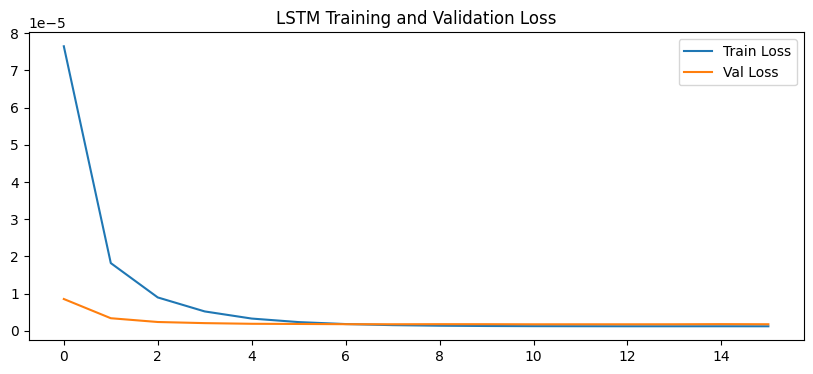

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history_final.history['loss'], label='Train Loss')
plt.plot(history_final.history['val_loss'], label='Val Loss')
plt.title("LSTM Training and Validation Loss")
plt.legend()
plt.show()

Section 10: Evaluation LSTM (RMSE & MAE)

Evaluation setup

- Test on unseen data

- Compute RMSE and MAE

RMSE

- Penalizes large errors

- Low value → rare major prediction mistakes

MAE

- Average prediction error

- Very low value → predictions close to actual rainfall

✅ Analyzing sample at Index: 2833
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

RMSE: 0.019278
MAE: 0.007042


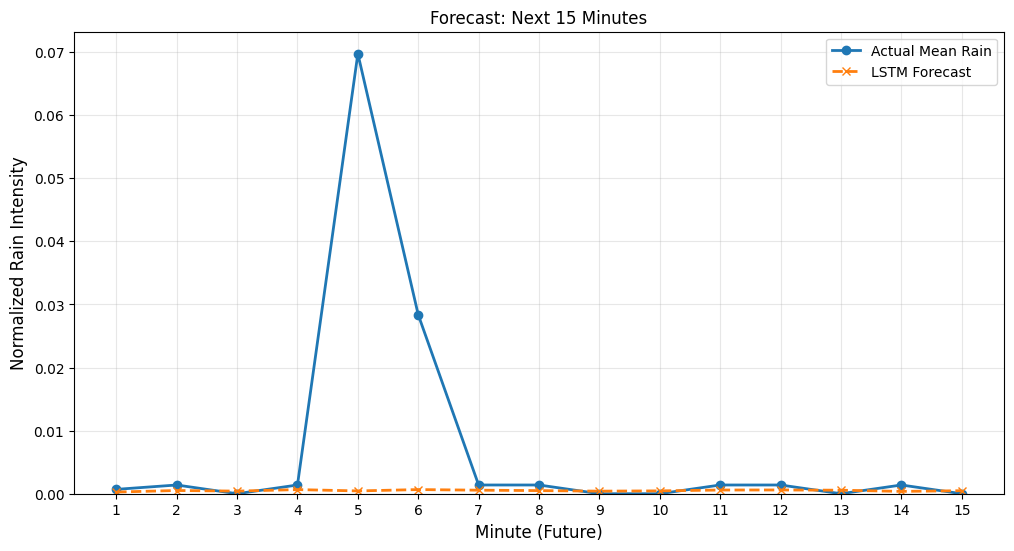

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 1. FIND A RAINY SAMPLE (Don't just plot sample 0)
# We will use a different index for this analysis
# Let's pick the next sample after the previously identified 'best_sample_idx'
# Ensure the index is within the bounds of Xte

# Check if best_sample_idx is defined and adjust
if 'best_sample_idx' not in globals() or best_sample_idx >= len(Yte) - 1:
    # If not defined or at the end of the test set, find a new 'rainy' sample
    best_sample_idx = 0
    max_rain_intensity = 0
    for i in range(len(Yte)):
        current_rain_sum = np.sum(Yte[i])
        if current_rain_sum > max_rain_intensity:
            max_rain_intensity = current_rain_sum
            best_sample_idx = i

already_analyzed_idx = best_sample_idx # Store the previously found best

# Try to get the next sample, if it exists
if already_analyzed_idx + 1 < len(Yte):
    current_sample_idx = already_analyzed_idx + 1
else:
    # If the next one is out of bounds, wrap around or pick a different one (e.g., first)
    current_sample_idx = 0 # Or any other valid index

print(f"✅ Analyzing sample at Index: {current_sample_idx}")

# 2. PREDICT & FIX NEGATIVES
# Get the specific sample
sample_input = Xte[current_sample_idx].reshape(1, opt["T"], CSV_FEATURES)
y_true_sample = Yte[current_sample_idx] # Shape: (K,)

# Predict
pred_raw = final_model.predict(sample_input)[0] # Shape: (K,)

# FORCE PHYSICS: Rain cannot be negative
pred_fixed = np.maximum(pred_raw, 0)

# 3. AGGREGATE SPATIAL FEATURES (Mean of 723 points)
# Since LSTM predicts K scalar values (already aggregated), no further mean is needed.
# y_true_sample is already (K,) and pred_fixed is already (K,)
y_true_mean = y_true_sample
y_pred_mean = pred_fixed

# Calculate RMSE and MAE
rmse = np.sqrt(mean_squared_error(y_true_mean, y_pred_mean))
mae = mean_absolute_error(y_true_mean, y_pred_mean)

print(f"\nRMSE: {rmse:.6f}")
print(f"MAE: {mae:.6f}")

# 4. PLOT PROFESSIONAL GRAPH
plt.figure(figsize=(12, 6))
plt.plot(range(1, 16), y_true_mean, marker='o', linewidth=2, label="Actual Mean Rain", color='tab:blue')
plt.plot(range(1, 16), y_pred_mean, marker='x', linestyle='--', linewidth=2, label="LSTM Forecast", color='tab:orange')

plt.title(f"Forecast: Next 15 Minutes")
plt.xlabel("Minute (Future)", fontsize=12)
plt.ylabel("Normalized Rain Intensity", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 16))
plt.ylim(bottom=0)
plt.show()